In [147]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [148]:
## 1)Read the university subjects and find the positive and negative subjects.

In [149]:
# 读取 Excel 文件
middleSchool_userProfile_file = r'C:\Users\Administrator\Desktop\Backend-Algorithm\Algorithm\PPG\ppg_vitality\data_preprocess\middle_school_data_vitality.xlsx'


In [150]:
stress_positive_threshold = 20.0
stress_negative_threshold = 10.0

In [151]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file)
df_middle = df_middle[(df_middle['vitality_sum'] > stress_positive_threshold) | (df_middle['vitality_sum'] < stress_negative_threshold)]
print(f"Midlle schold available subject count: {df_middle.shape}")


middle_pos_subjects = df_middle[df_middle['vitality_sum'] > stress_positive_threshold]['userId'].values.tolist()
middle_neg_subjects = df_middle[df_middle['vitality_sum'] < stress_negative_threshold]['userId'].values.tolist()

print(f"middle stress positive subjects count: {len(middle_pos_subjects)}")
print(f"middle stress negative subjects count: {len(middle_neg_subjects)}")

Midlle schold available subject count: (229, 30)
middle stress positive subjects count: 119
middle stress negative subjects count: 110


In [152]:
profile_dict = dict()


for _, row in df_middle.iterrows():
    userId = row['userId']
    gender = row['gender']
    age = row['age']
    profile_dict[userId] = (gender, age)

# for key, val in profile_dict.items():
#     print(f"userId: {key}, value: {val}")


In [153]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 15
val_subject_count = 10

test_pos_subjects = middle_pos_subjects[0:test_subject_count]
test_neg_subjects = middle_neg_subjects[0:test_subject_count]

val_pos_subjects = middle_pos_subjects[test_subject_count:test_subject_count+val_subject_count]
val_neg_subjects = middle_neg_subjects[test_subject_count:test_subject_count+val_subject_count]

train_pos_subjects = middle_pos_subjects[test_subject_count+val_subject_count::] 
train_neg_subjects = middle_neg_subjects[test_subject_count+val_subject_count::]

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"validation postive subjects: {len(val_pos_subjects)}")
print(f"validation negative subjects: {len(val_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 94
train negative subjects: 85
validation postive subjects: 10
validation negative subjects: 10
test postive subjects: 15
test negative subjects: 15


In [154]:
def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['RawResults'][0]['rawDatas']
            final = [i/100000 for i in list_data]
        return final
    except (KeyError, IndexError, TypeError):
        with open(path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data["datas"]


In [155]:
sample_freq = 125
sample_window_minute = 0.5
middle_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data'


In [156]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []
            # The middle school subjects.
            if subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave

            if len(subject_wave) < (sample_freq * sample_window_minute * 60):
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset


train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=1)
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\329722100720414168622899260498795872497.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\222680082272891873550031063122351047131.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\264207734182230936694056901818680720748.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\85368278269151765477300734597278915014.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\184844450584012464414507368311518109093.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\45689668389451576382630761467329343328.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\10348344887721703023657404421332

In [157]:
val_pos_dataset = generate_dataset(val_pos_subjects, label=1, data_aug_times=1)
val_neg_dataset = generate_dataset(val_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\118672804470933314296119930305882830161.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\27384113139794060774257569632727978954.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\262125641357055355562730650708875843490.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\220381491508493212398664224112476321788.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\97787519318640743833349948562306113456.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\18868260396363831327592014345363505401.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\339939524909687247847286715934976

In [158]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\123186721412066420945661329342422604187.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\183915054561536545436523543092310451958.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\299837823671669493591048353351617715401.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\113980445301479007579616920795423718103.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\265969244215005771336396286117970459836.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\178911033606610348263471481613906161862.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\332968452519435402818851714314

In [159]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"val pos sample shape: {val_pos_dataset.shape}")
print(f"val neg sample shape: {val_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (425, 40)
train neg sample shape: (396, 40)
val pos sample shape: (43, 40)
val neg sample shape: (52, 40)
test pos sample shape: (74, 40)
test neg sample shape: (69, 40)


In [160]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

val_pos_dataset_final = val_pos_dataset.drop(columns=columns_drop, inplace=False)
val_neg_dataset_final = val_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [161]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, validation pos shape: {val_pos_dataset_final.shape}")
print(f"After remove the invalid columns, validation neg shape: {val_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (425, 29)
After remove the invalid columns, train neg shape: (396, 29)
After remove the invalid columns, validation pos shape: (43, 29)
After remove the invalid columns, validation neg shape: (52, 29)
After remove the invalid columns, test pos shape: (69, 29)
After remove the invalid columns, test neg shape: (74, 29)


#### Do The Normalization for the Train Dataset and Test Dataset

In [162]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [163]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_sleep_norm_minmax_values_{current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_sleep_norm_minmax_values_{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']


val_pos_dataset_final[columns_to_normalize] = normalize(val_pos_dataset_final[columns_to_normalize], min_values, max_values)
val_neg_dataset_final[columns_to_normalize] = normalize(val_neg_dataset_final[columns_to_normalize], min_values, max_values)


# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

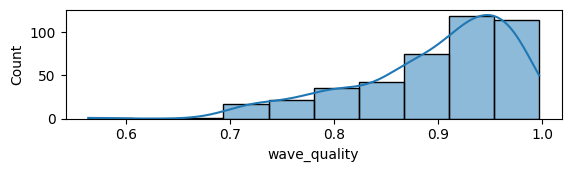

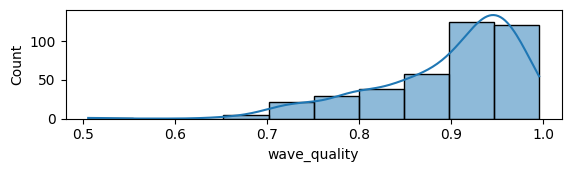

<Axes: xlabel='wave_quality', ylabel='Count'>

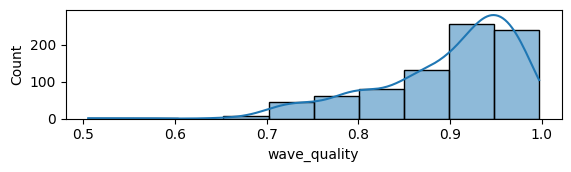

In [165]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [166]:
wave_quality_threshold = 0.9

In [167]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"validation pos sample shape: {val_pos_dataset.shape}")
print(f"validation neg sample shape: {val_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (425, 40)
train neg sample shape: (396, 40)
validation pos sample shape: (43, 40)
validation neg sample shape: (52, 40)
test pos sample shape: (74, 40)
test neg sample shape: (69, 40)


In [168]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 249
After quality filter, train negative sample count: 243


In [169]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)

# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
val_pos_path = os.path.join(sample_folder, 'val_pos_dataset.pkl')
val_neg_path = os.path.join(sample_folder, 'val_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)

val_pos_dataset_final[val_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(val_pos_path)
val_neg_dataset_final[val_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(val_neg_path)

test_pos_dataset_final[test_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_pos_path)
test_neg_dataset_final[test_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_neg_path)

In [170]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')
